# M3 Metric Analysis

The tabular results of evaluating the M3 metric for extended object counts for the RGPS survey design.  All science cases can be found in the metric_results/ directory.  The goal of this notebook is to explore those results in graphical form. 

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

First we need to load some of the configuration information for the metric simulation for future reference.

In [3]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [4]:
# Load the survey regions
all_survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_survey_regions.json'))

In [5]:
# Load definitions of science cases and extract the set of topical categories
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])
science_categories

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


['wide_area',
 'time_domain',
 'SFR',
 'solar_system',
 'high_cadence',
 'globular_clusters',
 'molecular_clouds',
 'AGN',
 'open_clusters',
 'variable_stars',
 'galactic_center',
 'keyholes',
 'stellar_spectra',
 'extinction',
 'novae',
 'ISM',
 'YSO',
 'GW']

## M3 Extended Object Metric

A number of science cases expressed an interest in observing as many targets as possible from a known catalog of objects. There are several examples of these, including Open and Globular Clusters, Star Forming Regions, and Active Galactic Nuclei. The metrics to evaluate these cases are fundamentally the same - calculating the percentage (by area) of the target catalog to receive observations in the requested filters - the code was combined into a single metric which accepts different target catalogs of interest.

It is therefore most relevant to examine the results of this metric for those science cases which cited input target catalogs rather than all of them. These can be found by searching the rgps_science_cases.json file for science cases with flag 'extended_object_catalog' set to true. These include:

* DAmmando - jetted AGN
* Villasenor - Young massive stars in HII regions
* De_Furio - Star Forming Regions
* Globular_clusters
* Open_clusters

Note that not all proposals listing SFRs or clusters are so labeled, since some proposals aim to perform wide-area surveys in order to detect more clusters rather than to cover a catalog of known objects.

In [6]:
# Load the M3 metric results
m3_results_file = path.join(getcwd(), '..', 'metric_results', 'M3_extended_region_count_results.txt')

m3_results = Table.read(m3_results_file, format='ascii')
m3_results

Survey_strategy,Optic,Science_case,Category,M3_%regions
str12,str4,str17,str17,float64
wide_area,F184,DAmmando,AGN,6.6339066339066335
panchromatic,F184,DAmmando,AGN,1.71990171990172
time_domain,F184,DAmmando,AGN,0.0
wide_area,F062,Villasenor,molecular_clouds,0.0
panchromatic,F062,Villasenor,molecular_clouds,38.63636363636363
time_domain,F062,Villasenor,molecular_clouds,15.909090909090908
wide_area,F129,Villasenor,molecular_clouds,56.81818181818182
panchromatic,F129,Villasenor,molecular_clouds,40.909090909090914
time_domain,F129,Villasenor,molecular_clouds,15.909090909090908


In [7]:
def plot_metric_per_strategy(results, metric_name, sim_config, metric_label, survey_name): 
    """
    Function to plot metric values for different science use cases for a specific survey design, for multiple filters.

    Input
        selected_results  Table   Metric results table selecting the output for a specific science case only.
    """

    # Select the results for the specified survey strategy
    idx = np.where(results['Survey_strategy'] == survey_name)[0]
    selected_results = results[idx]

    # Create a set of the science cases 
    case_set = list(set(selected_results['Science_case'].data))
    case_set.sort()
    case_labels = []
    exceptions = ['Globular_Clusters', 'Open_Clusters']
    for label in case_set:
        if label in exceptions:
            case_labels.append(label)
        else:
            idx = np.where(selected_results['Science_case'] == label)[0]
            case_labels.append(label + '\n(' + selected_results['Category'].data[idx[0]] + ')')
    xrange = np.arange(0, len(case_set), 1)
    
    # Identify which filters were requested for this science case
    filter_set = list(set(selected_results['Optic'].data))
    filter_set.sort()
    bar_width = 1.0 / (len(filter_set)+2)

    # Plot the metric results 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

    for j, optic in enumerate(filter_set):

        bar_offset = bar_width * (j - j/len(filter_set))
        
        fdx = selected_results['Optic'] == optic
        metric_filter = selected_results[fdx]
        
        data = []
        for i,case in enumerate(case_set):
            jdx = np.where(metric_filter['Science_case'] == case)[0]
            if len(metric_filter[jdx]) > 0:
                data.append([i+bar_offset, metric_filter[jdx][metric_name][0]])

        if len(data) > 0:
            data = np.array(data)
            
            #ax.plot(data[:,0], data[:,1], 
            #        color=sim_config['PLOT_COLORS'][optic], marker=sim_config['PLOT_SYMBOLS'][optic],
            #        linestyle='none', label=optic)
            ax.bar(data[:,0], data[:,1], bar_width,
                    color=sim_config['PLOT_COLORS'][optic],
                    linestyle='none', label=optic)

    (ymin, ymax) = ax.get_ylim()
    for x in xrange:
        ax.plot([x,x], [ymin, ymax], color='grey', linestyle='-.', alpha=0.4)
    
    ax.set_xlabel('Science case', fontsize=20)
    ax.set_ylabel(metric_label, fontsize=20)
    ax.set_title(metric_name + ' for ' + survey_name + ' survey', fontsize=20)
    ax.set_xticks(np.arange(0,len(case_set),1) + 0.5)
    ax.set_xticklabels(case_labels, rotation=45.0, horizontalalignment='right', fontsize=20)
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=20, horizontalalignment='right')
    ax.legend(fontsize=18, loc='upper right')

    plt.tight_layout()
    plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm3_results_' + survey_name + '.png'))

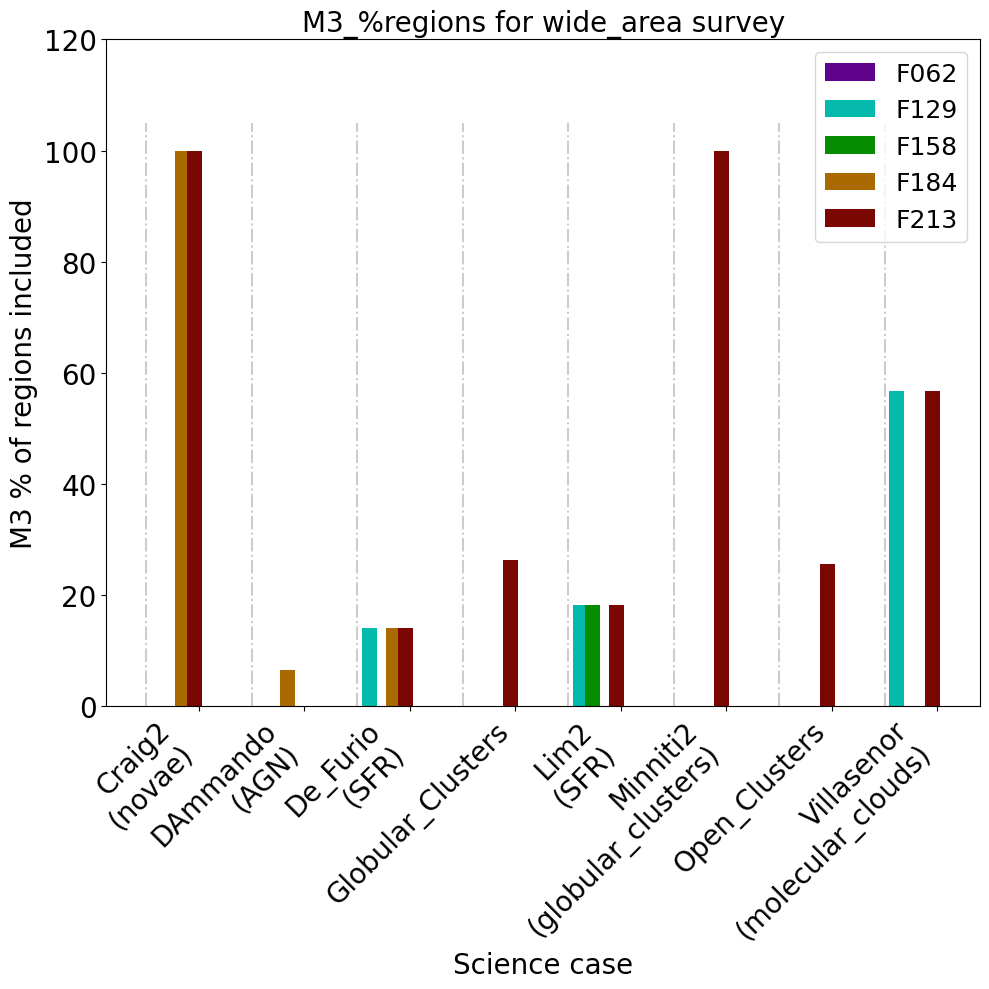

In [8]:
plot_metric_per_strategy(m3_results, 'M3_%regions', sim_config, 'M3 % of regions included', 'wide_area')

Bearing in mind that this metric returns a percentage of the total sky area subtended by all objects in each catalog, these results cover a wide range.  However, many objects (e.g. SFRs) subtend large areas as seen from Earth, much of which is well outside the Galactic Plane and covered by other Roman surveys.  The percentage coverage for the Globular_Clusters and Open_Clusters catalogs should be interpreted with this in mind, since these include all known objects across the whole sky.  

Instead, some of the other science cases, such as Minniti2, recommended certain high priority clusters, so the coverage statistics in this case is more representative.  

This can be illustrated by considering some of the science cases that proposed a smaller subset of SFR targets, such as Werner who requested coverage of Orion SFR, Rho Ophiuchi SFR, and Taurus SFR.  Unfortunately the current survey designs provide no coverage of these regions. 